In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from node2vec import Node2Vec as n2v

e:\Data Mining\DM_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


generate network of articles

In [12]:
def generate_network(df, node_col = 'article_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

research_df = pd.read_csv('./arxiv_data.csv')

all_tp = research_df.explode('all_topics').copy()

tp_nx = generate_network(
    all_tp, 
    node_col = 'article_id', 
    edge_col = 'all_topics'
)

print(nx.info(tp_nx))

Graph with 4514 nodes and 114804 edges


C:\Users\Dell\AppData\Local\Temp\ipykernel_7780\2606017599.py:44: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(tp_nx))


Generate Embeddings using node2vec

In [13]:
g_emb = n2v(tp_nx, dimensions=16)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

# create embeddings dataframe
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in tp_nx.nodes()],
        index = tp_nx.nodes
    )
)

print(emb_df.head())

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


         0         1         2         3         4         5         6   \
0 -0.063843  0.057878  1.019668  0.737463 -1.624158 -0.281398 -0.197343   
1  1.526637 -1.191299 -1.117636  0.929756  0.638183 -0.706727 -2.541464   
2  1.633633 -2.578868 -1.372774  2.268178 -0.481535 -1.072821  0.684363   
3  1.073345 -1.704269  0.890125  1.045025 -0.262377  1.131993  0.796528   
4 -0.089140  0.132773  1.068523  0.781315 -1.625818 -0.214917 -0.232448   

         7         8         9         10        11        12        13  \
0 -2.107599 -1.316027  0.394002 -1.365447 -0.597148 -0.442192 -0.731211   
1 -2.722081  0.714583  1.089361 -1.767422  0.937907 -0.001169 -0.730538   
2 -2.100762  0.271022  0.094620 -0.534775  0.088832 -0.770093 -0.784769   
3 -2.276815  0.639127  0.581596 -0.761255 -0.293505  0.413757  0.570558   
4 -2.134468 -1.325822  0.394848 -1.404162 -0.627880 -0.474049 -0.711567   

         14        15  
0  0.549766 -0.301338  
1  1.753731  1.415054  
2  1.061564  0.383419  
3 

Recommendation with Distance meausure


In [26]:
def predict_links(G, df, article_id, N):
    '''
    This function will predict the top N links a node (article_id) should be connected with
    which it is not already connected with in G.
    
    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        article_id (Integer) : The article you're interested 
        N (Integer) : The number of recommended links you want to return
        
    returns:
        This function will return a list of nodes the input node should be connected with.
    '''
    
    # separate target article with all others
    article = df[df.index == article_id]
    
    # other articles are all articles which the current doesn't have an edge connecting
    all_nodes = G.nodes()
    other_nodes = [n for n in all_nodes if n not in list(G.adj[article_id]) + [article_id]]
    other_articles = df[df.index.isin(other_nodes)]
    
    # get similarity of current reader and all other readers
    sim = cosine_similarity(article, other_articles)[0].tolist()
    idx = other_articles.index.tolist()
    
    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)
    
    similar_articles = idx_sim[:N]
    articles = [art[0] for art in similar_articles]
    return articles
  
predict_links(G = tp_nx, df = emb_df, article_id = 7, N = 10)

[4425, 2312, 551, 4443, 1021, 3053, 2408, 721, 2421, 2327]

Vizualize Embeddings


[]

<Figure size 640x480 with 0 Axes>

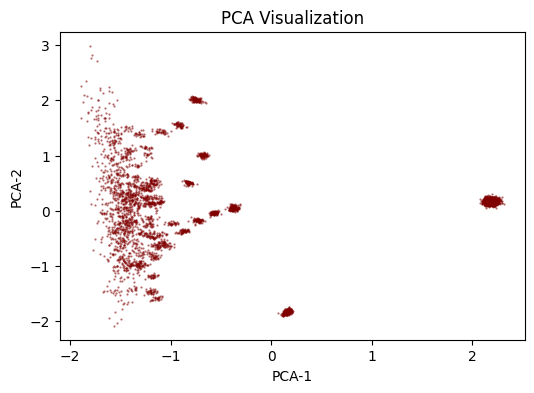

In [22]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()